# Example of reading tracker ROOT Trees into a pandas data frame for Python analysis 🖥
## See here more details: https://cdcvs.fnal.gov/redmine/projects/gm2analyses/wiki/Python-based_EDM_analysis

### First import the necessary modules

In [4]:
import sys,os
import numpy as np
sys.path.append(os.environ["JUPYROOT"]) # where JUPYROOT is path to ROOT e.g. /usr/local/Cellar/root/6.18.04/lib/root
# for Python3 install root_numpy with "python3 -m pip install --user root_numpy"
import root_numpy # see http://scikit-hep.org/root_numpy/install.html  
# for Python3 install root_pandas with "python3 -m pip install --user root_pandas"
from root_pandas import read_root # see https://github.com/scikit-hep/root_pandas 

## Read in the ROOT Trees into a pandas data frame

In [5]:
data_all = read_root("../DATA/Trees/sim_test2.root", 'trackerNTup/tracker')

### Calculate vetex momentum (as a new column)

In [6]:
data_all['decayVertexMom'] = np.sqrt(data_all["decayVertexMomX"]**2 + data_all["decayVertexMomY"]**2 + data_all["decayVertexMomZ"]**2)

### From all data select only what we need

In [18]:
mom_cut = (data_all['decayVertexMom'] > 700) & (data_all['decayVertexMom'] < 1700)

In [19]:
data = data_all[mom_cut].loc[:, ["decayVertexMom", "decayVertexMomY", "trackT0", "station", "hitVolume", "passVertexQuality", ]]

### ns - > us 

In [20]:
data["trackT0"]=data["trackT0"]*1e-3

### Get glimpse of data

In [21]:
data

,decayVertexMom,decayVertexMomY,trackT0,station,hitVolume,passVertexQuality
10,1534.245972,44.120983,229.475098,12,False,False
11,1373.373169,-3.547505,128.146317,0,False,False
12,1273.693115,-25.078747,11.015006,12,True,False
16,772.100403,-43.096775,29.667305,12,False,False
17,810.329468,6.853809,11.662471,12,True,False
...,...,...,...,...,...,...
111931,1029.424194,-6.234702,71.998360,18,False,False
111933,1314.330444,-29.205427,2.653927,0,False,False
111934,1679.070679,41.102791,79.263962,12,True,False
111936,1152.520996,-10.193842,7.207133,0,True,False


# Now let's plot something!

## Sanity plot of momentum

We have 6.19e+04 tracks in this array, with the mean momentum of  1183.5496 MeV
Plotting for 1M:


(0, 3500)

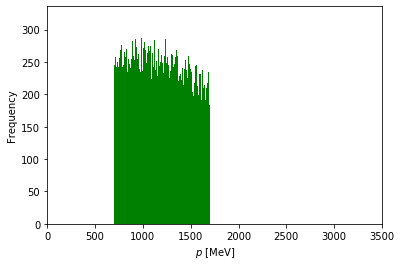

In [22]:
p = data['decayVertexMom']
p_mean = p.mean()
ax = p[0:int(1e6)].plot.hist(bins=250, color="green")
ax.set_xlabel(r"$p$ [MeV]")
print("We have", "{:.2e}".format(len(p)), "tracks in this array, with the mean momentum of ", p_mean, "MeV")
print("Plotting for 1M:")
fig = ax.get_figure()
ax.set_xlim(0, 3500)
# fig.savefig('p.png', dpi=300)

Now get $\theta_y = atan2(\frac{p_y}{p})$ (in mrad) and modulated $g-2$ time (in us, already done above)

In [11]:
theta_y = np.arctan2(data["decayVertexMomY"], data["decayVertexMom"]) *1e3 # mrad 
omegaAMagic = 0.00143934 # from gm2geom consts / kHz 
g2period = (2*np.pi / omegaAMagic ) * 1e-3 # us 
g2fracTimeReco = data["trackT0"] / g2period
g2fracTimeRecoInt = g2fracTimeReco.astype(int)
modulog2TimeReco = (g2fracTimeReco - g2fracTimeRecoInt) * g2period

### Now do some serious plotting

In [15]:
import os, sys
sys.path.append('../CommonUtils/')
import CommonUtils as cu
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

x,y,p=modulog2TimeReco,theta_y,data["decayVertexMomY"]

### Create (df_binned) profile DF and plot the profile

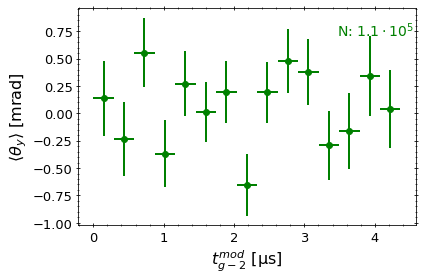

In [13]:
fig,ax=plt.subplots()
ax, df_binned, df_input =cu.Profile(x, y, ax, nbins=15, xmin=np.min(x),xmax=np.max(x), mean=True)
ax.set_ylabel(r"$\langle\theta_y\rangle$ [mrad]", fontsize=16)
ax.set_xlabel(r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", fontsize=16)
N=cu.sci_notation(len(x)) # format as a 
cu.textL(ax, 0.88, 0.9, "N: "+N, font_size=14)
plt.tight_layout() 
plt.savefig("../fig/profile.png")